## Задача 5. Оценить поток момента импульса через подстилающую поверхность по данным реанализа

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
filename = 'p-levels_t_u_v_geopotential.nc'
dataset = nc.Dataset(filename)
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-10-17 17:28:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data2/adaptor.mars.internal-1666027703.1958625-30550-12-dfaebb73-4318-41f5-8948-e364183edefd.nc /cache/tmp/dfaebb73-4318-41f5-8948-e364183edefd-adaptor.mars.internal-1666027700.738271-30550-14-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), level(3), time(3)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 level(level), int32 time(time), int16 z(time, level, latitude, longitude), int16 t(time, level, latitude, longitude), int16 u(time, level, latitude, longitude), int16 v(time, level, latitude, longitude)
    groups: 


In [3]:
lats = dataset['latitude'][:]
lons = dataset['longitude'][:]
time = dataset['time'][:]
p_level = dataset['level'][:]

data_u = dataset['u'][:]
data_v = dataset['v'][:]
data_t = dataset['t'][:]
data_z = dataset['z'][:]

In [4]:
filename2 = 'adaptor.mars.internal-1668087999.639294-29643-4-963282dc-f53a-415d-9b63-bc914ed135de.nc'
# zust - Friction velocity
# z - Geopotential
# metss - Mean eastward turbulent surface stress
# mngwss - Mean northward gravity wave surface stress
# sp - Surface pressure
dataset2 = nc.Dataset(filename2)
print(dataset2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-11-10 13:46:40 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data3/adaptor.mars.internal-1668087999.639294-29643-4-963282dc-f53a-415d-9b63-bc914ed135de.nc /cache/tmp/963282dc-f53a-415d-9b63-bc914ed135de-adaptor.mars.internal-1668087997.714299-29643-6-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), time(3)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 zust(time, latitude, longitude), int16 z(time, latitude, longitude), int16 metss(time, latitude, longitude), int16 mngwss(time, latitude, longitude), int16 sp(time, latitude, longitude)
    groups: 


In [5]:
data_sp = dataset2['sp'][:]
data_metss = dataset2['metss'][:]
data_mngwss = dataset2['mngwss'][:]
data_zust = dataset2['zust'][:]

g = 9.80665
a = 6371 * 10**3
omega = 1.995 * (10 ** -7)
data_zh = dataset2['z'][:] / g

In [6]:
def get_derivative(x, y):
    if len(y.shape) == 3:
        first_el = np.expand_dims(y[:, :, 0] / (x[1] - x[0]), axis=2)
        last_el =  np.expand_dims(y[:, :, -1] / (x[-1] - x[-2]), axis=2)
        dy = np.concatenate((first_el, (y[:, :, 2:] - y[:, :, :-2]) / (x[2:] - x[:-2]), last_el), axis=2)
    elif len(y.shape) == 1:
        first_el = y[0] / (x[1] - x[0])
        last_el = y[-1] / (x[-1] - x[-2])
        dy = np.append(first_el, (y[ 2:] - y[:-2]) / (x[2:] - x[:-2]))
        dy = np.append(dy, last_el)
    elif len(y.shape) == 2:
        first_el = np.expand_dims(y[:, 0] / (x[1] - x[0]), axis=1)
        last_el =  np.expand_dims(y[:, -1] / (x[-1] - x[-2]), axis=1)
        dy = np.concatenate((first_el, (y[:, 2:] - y[:, :-2]) / (x[2:] - x[:-2]), last_el), axis=1)
    else:
        dy = None
    return dy

In [7]:
def get_mul_product(x, y):
    x_shape = np.array(x.shape)
    idx = np.where(x_shape == y.shape[0])[0][0]
    mul_product = x.copy()
    with np.nditer(mul_product, flags=['multi_index'], op_flags=['writeonly']) as it:
        for el in it:
            el[...] = el * y[it.multi_index[idx]]
    return mul_product

def get_sum_product(x, y):
    x_shape = np.array(x.shape)
    idx = np.where(x_shape == y.shape[0])[0][0]
    mul_product = x.copy()
    with np.nditer(mul_product, flags=['multi_index'], op_flags=['writeonly']) as it:
        for el in it:
            el[...] = el + y[it.multi_index[idx]]
    return mul_product

$$ \frac{\partial }{\partial t} \Bigg(\overline{\overline{p_s M}^\lambda}^\sigma\Bigg)=-\frac{1}{a \cdot cos\varphi}\frac{\partial }{\partial \varphi}\Bigg(\overline{\overline{p_s M \cdot cos\varphi \cdot v}^\lambda}^\sigma\Bigg) - a g cos\varphi\Bigg[p_s \frac{\partial z_s}{\partial x} + \tau_{x, p}\Bigg]$$
 
$$ M = a\cdot cos\varphi(\Omega\cdot cos\varphi + u)$$
$$\frac{\partial}{\partial x} = \frac{\partial}{\partial a\cdot cos\varphi \cdot\lambda}$$
$g = 9.80665, a = 6371 \cdot 10^3, \Omega = 1.995 \cdot (10 ^ {-7})$
 
### Notation:

$ \varphi $ - lats <br>
$ \lambda $ - lons <br>
$ p_s $ - data_sp (surface pressure) <br>
$ \tau_{x, p} $ - data_mngwss (mean northward gravity wave surface stress) <br>
$ \frac{\partial }{\partial x} $ = get_derivative(x, )<br>


In [8]:
%%time
M = a * get_mul_product(get_sum_product(data_u, omega * np.cos(lats)), np.cos(lats))
dy = np.mean(get_mul_product(data_sp, np.cos(lats)) * M * data_v, axis=3)
dy = np.mean(dy, axis=1)

first_component = -1 / (a * np.cos(lats)) * get_derivative(lats, dy)
second_component = -g * data_sp * get_derivative(lons, data_zh)
third_component = a * g * get_mul_product(data_mngwss, np.cos(lats))

CPU times: user 54.5 s, sys: 32.7 ms, total: 54.5 s
Wall time: 54.5 s


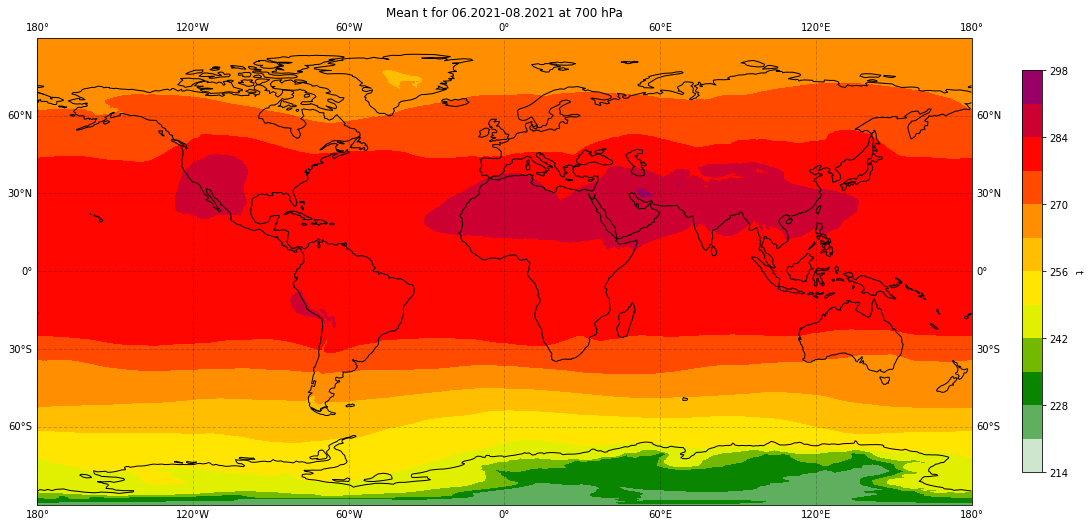

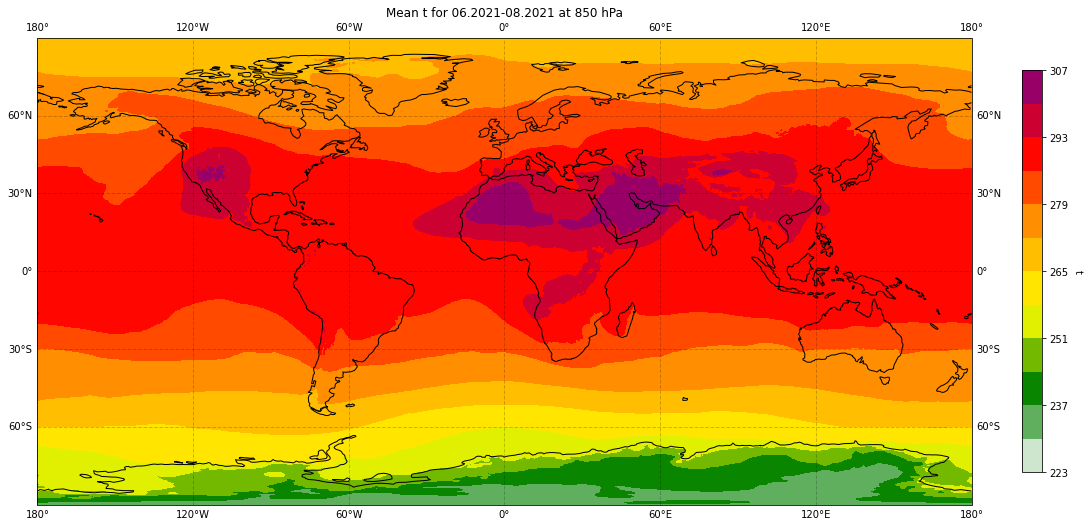

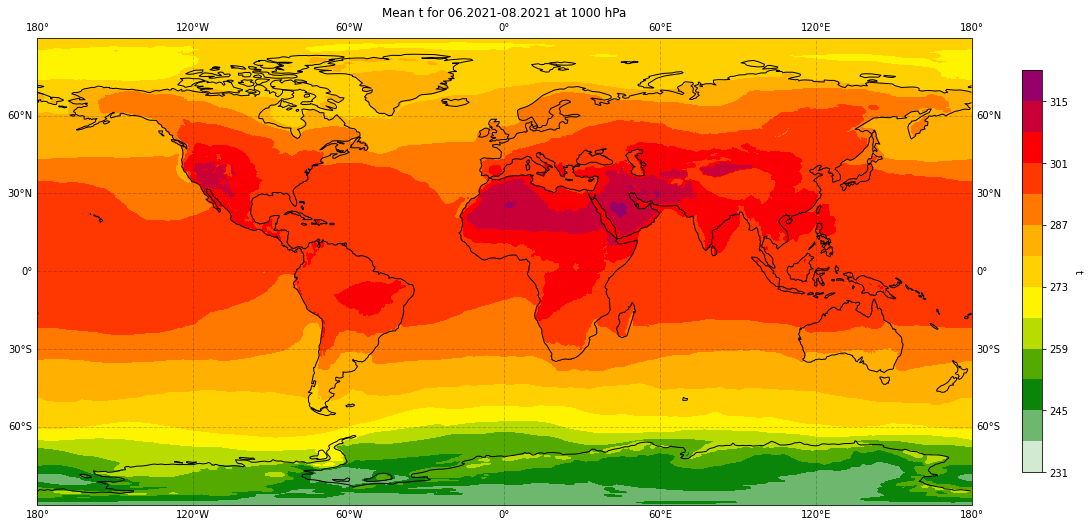

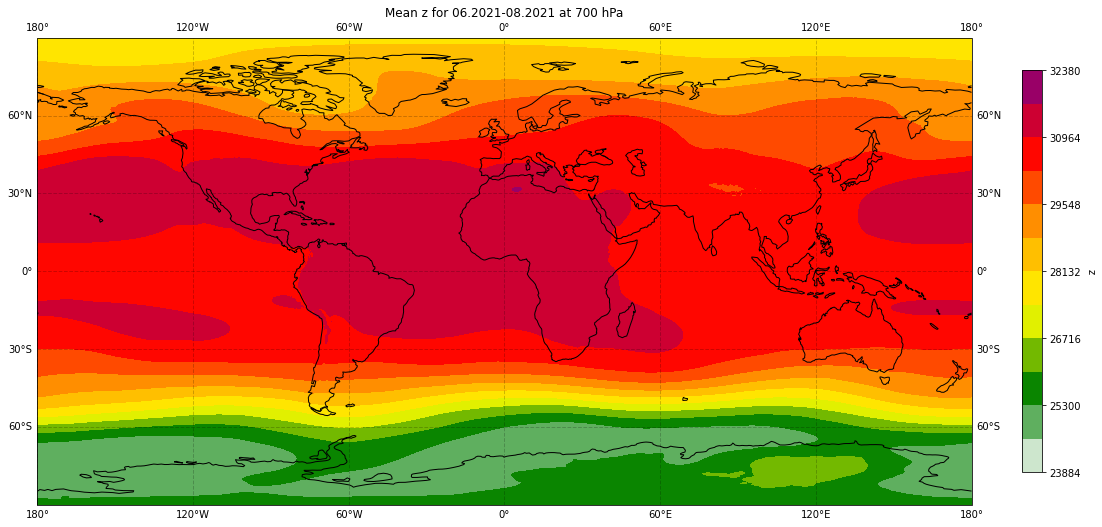

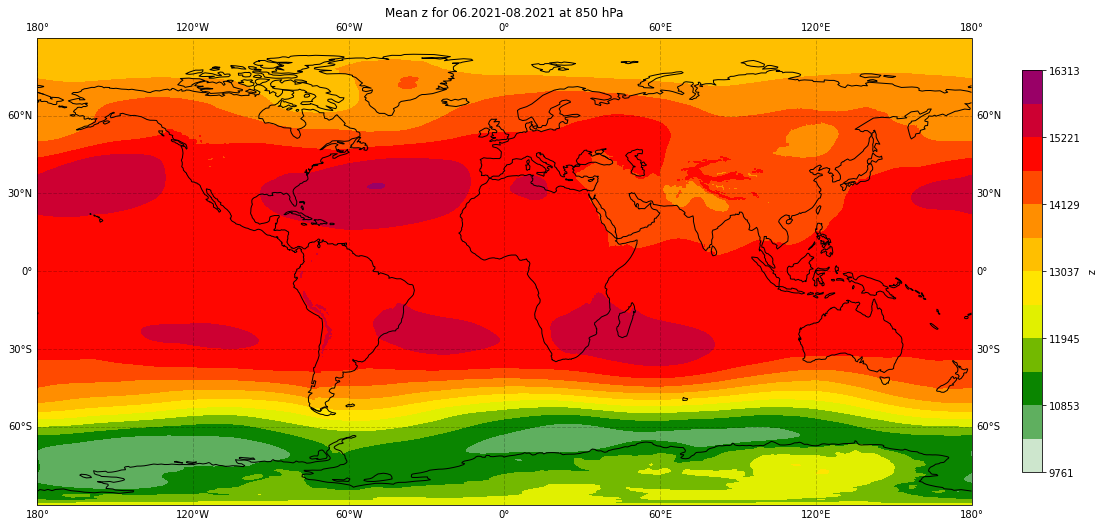

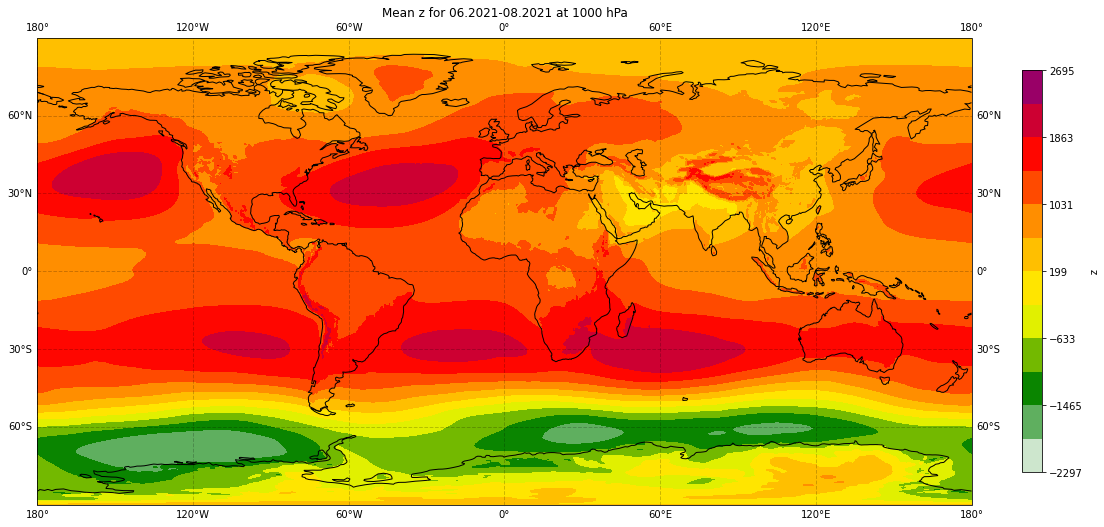

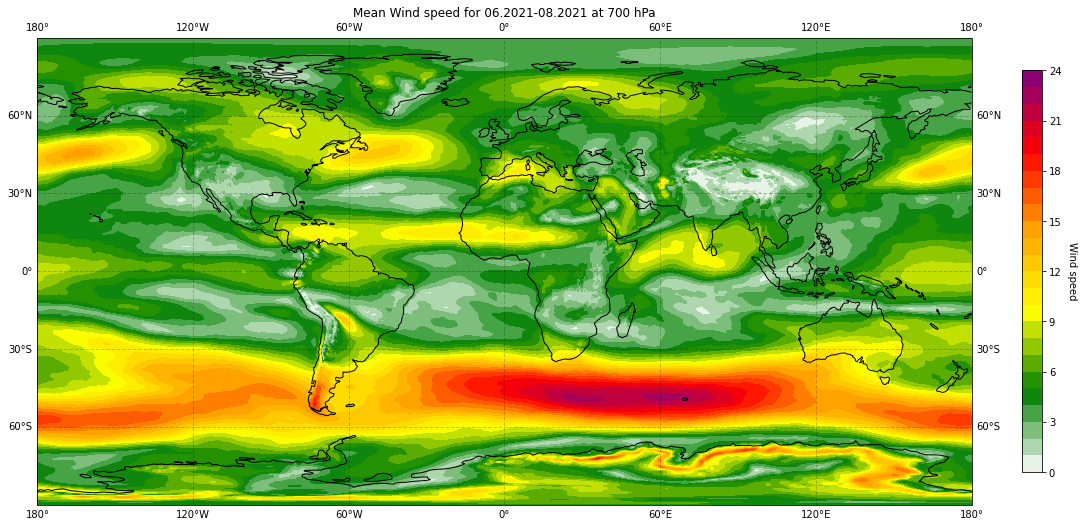

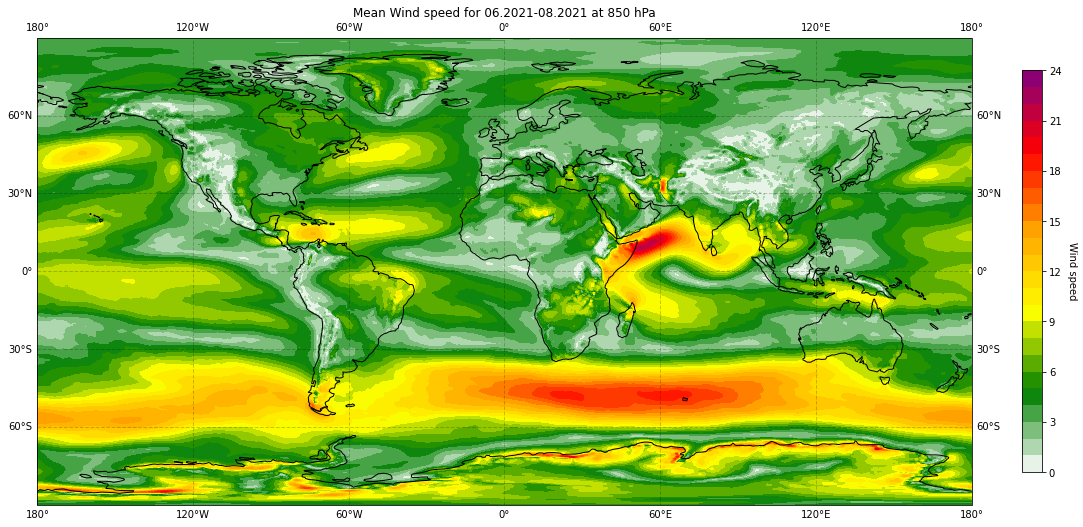

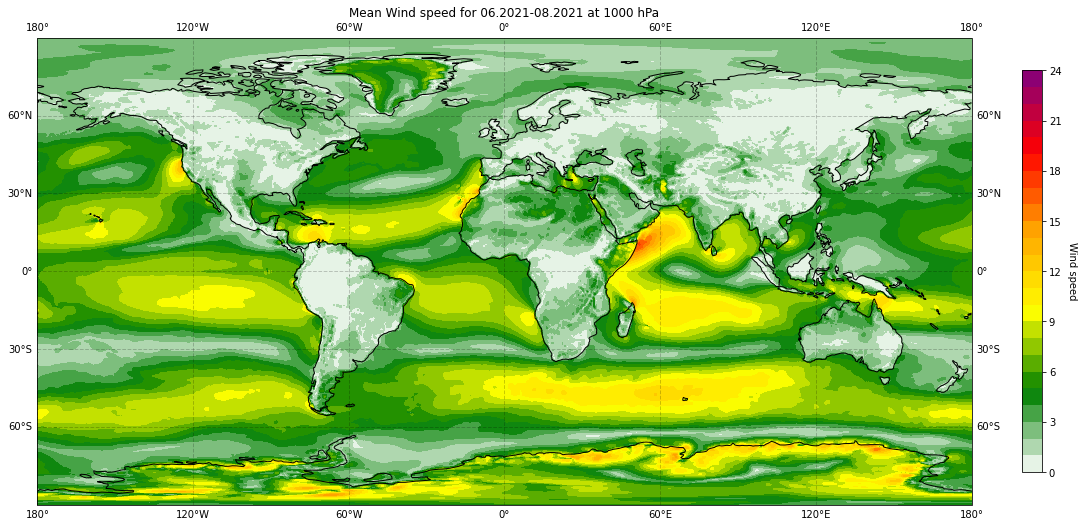

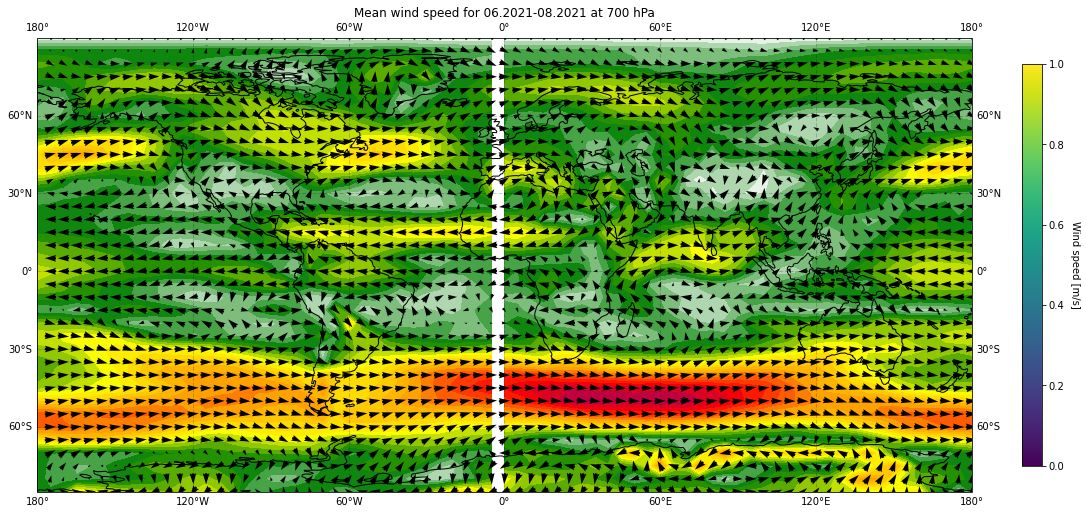

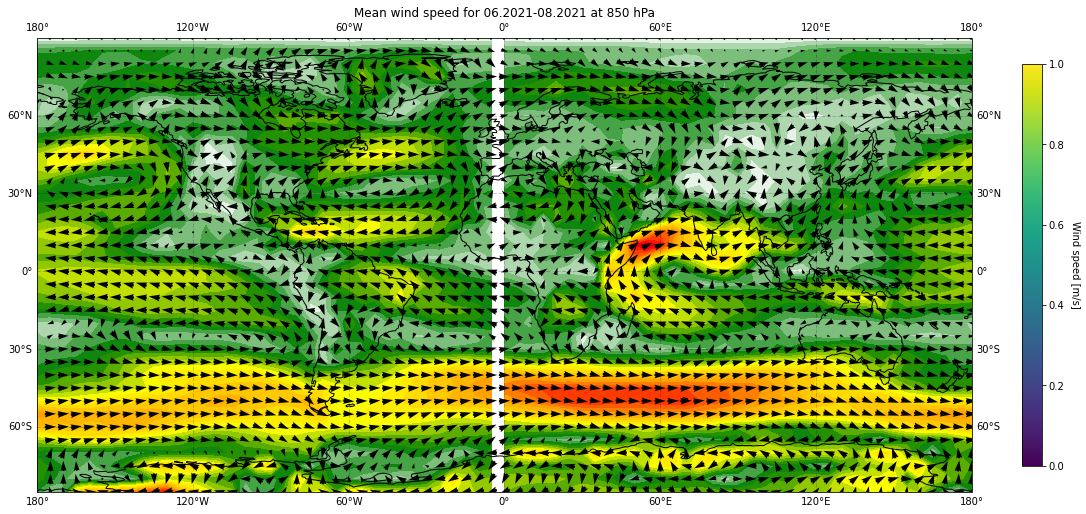

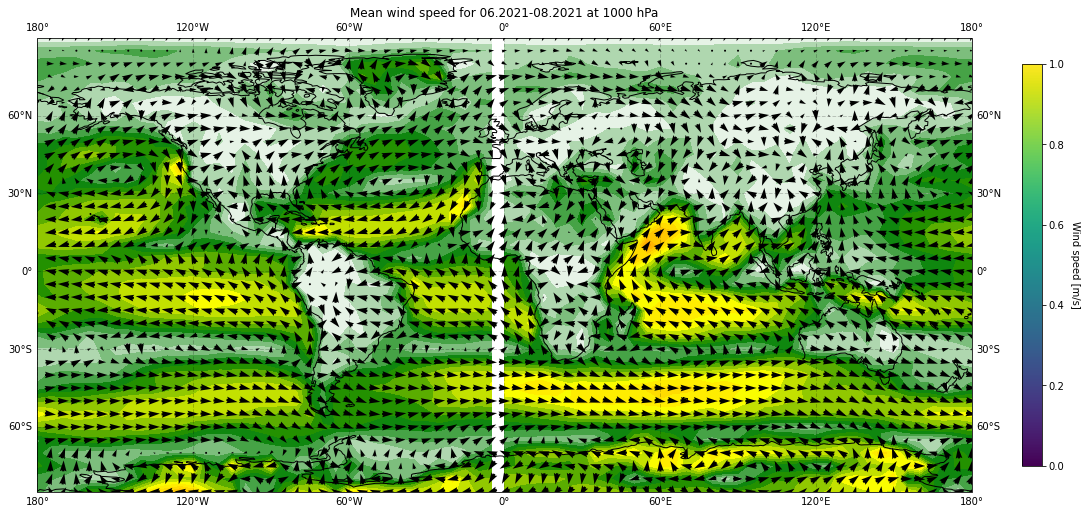

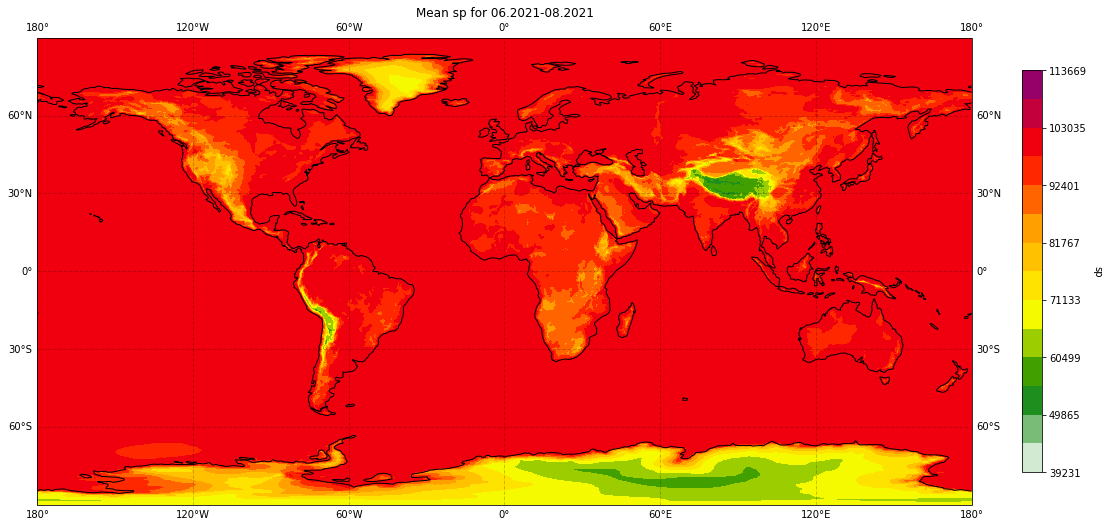

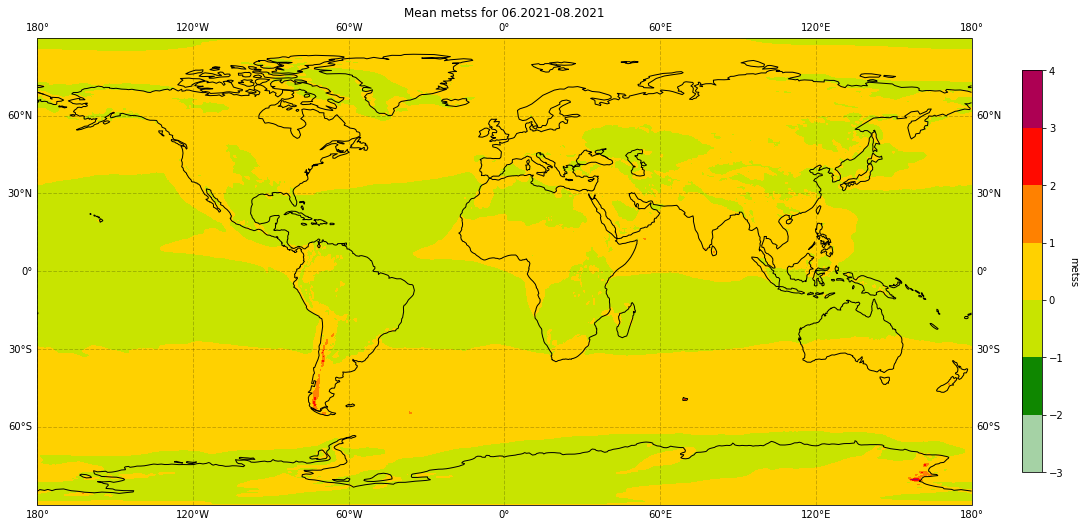

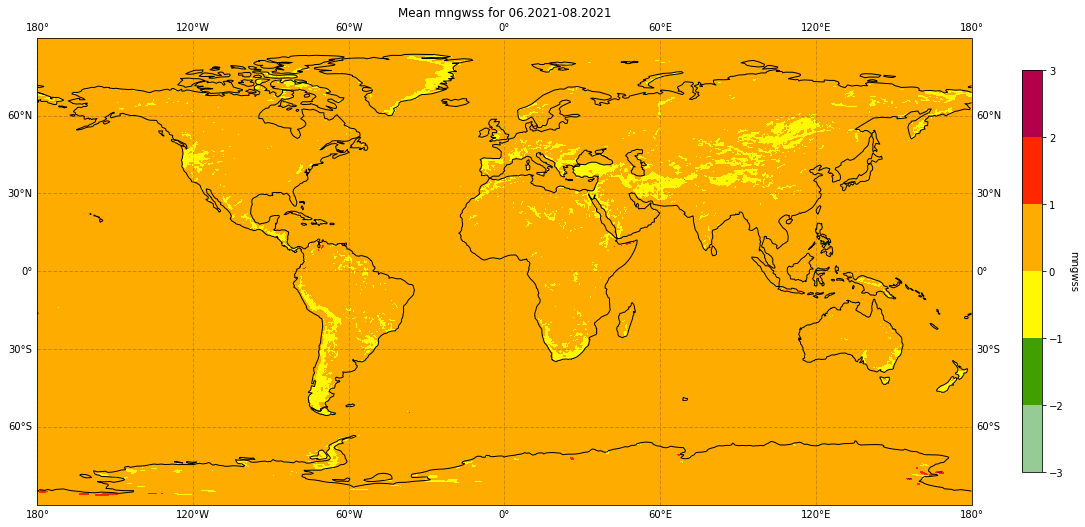

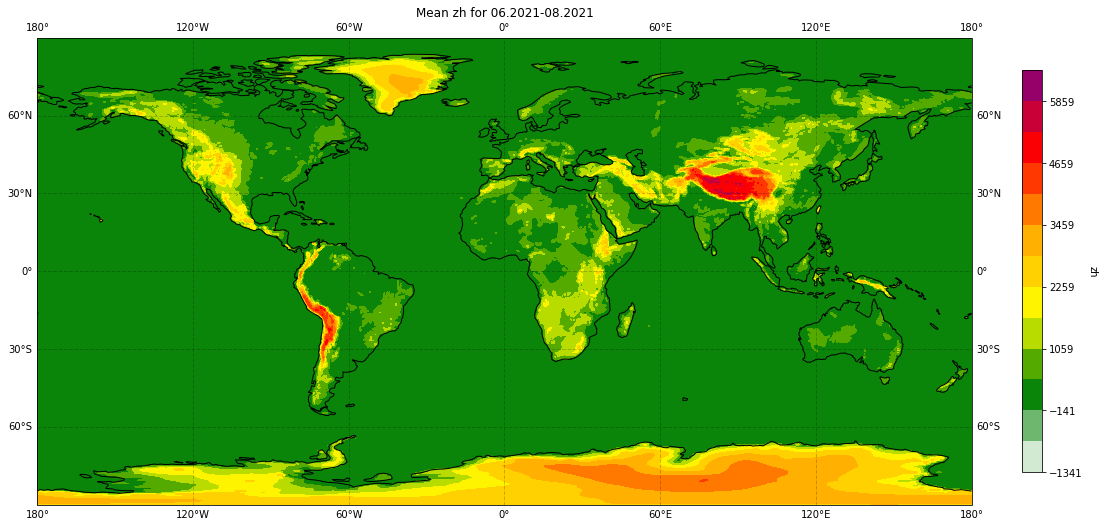

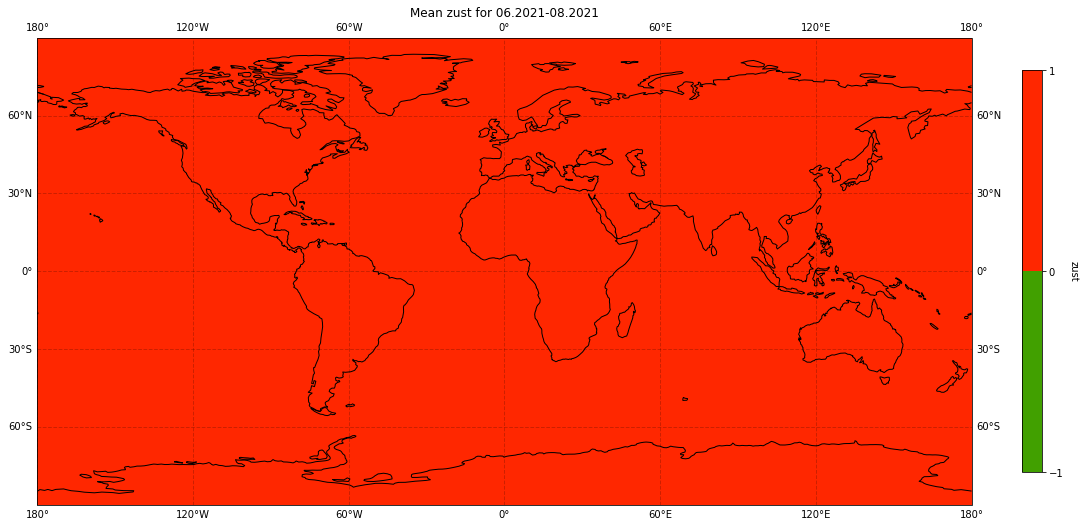

In [9]:
to_plot = False
if to_plot:
    data_windspeed = np.sqrt(data_u ** 2 + data_v ** 2) 
    data_windspeed_summer_mean = np.mean(data_windspeed, axis = 0)
    data_u_mean = np.mean(data_u, axis = 0)
    data_v_mean = np.mean(data_v, axis = 0)
    data_t_mean = np.mean(data_t, axis = 0)
    data_z_mean = np.mean(data_z, axis = 0)

    data_u_mean_norm = data_u_mean / data_windspeed_summer_mean
    data_v_mean_norm = data_v_mean / data_windspeed_summer_mean

    data_sp_mean = np.mean(data_sp, axis = 0)
    data_metss_mean = np.mean(data_metss, axis = 0)
    data_mngwss_mean = np.mean(data_mngwss, axis = 0)
    data_zh_mean = np.mean(data_zh, axis = 0)
    data_zust_mean = np.mean(data_zust, axis = 0)

    data = zip(
        ['sp', 'metss', 'mngwss', 'zh', 'zust'],
        [data_sp_mean, data_metss_mean, data_mngwss_mean, data_zh_mean, data_zust_mean])

    # Теперь построим карты средней за лето скорости ветра для каждой из высот (уровней давления)

    data_crs = ccrs.PlateCarree()

    # Можем создать собственную цветовую палитру для карт, выбрав нужные цвета и их порядок
    newcmp = LinearSegmentedColormap.from_list('', ['white', 'green', 'yellow', 'orange', 'red', 'purple'])

    # Создаём цикл, в котором итератор p_i пройдёт по всем уровням давления - будет меняться от 0 
    # до длины массива уровней давления (p_level) невключительно, то есть примет значения 0, 1 и 2. 
    for name, el in zip(['t', 'z', 'Wind speed'], [data_t_mean, data_z_mean, data_windspeed_summer_mean]):
        for p_i in range(len(p_level)):
            f = plt.figure(figsize = (18, 9))
            f.patch.set_facecolor('white')

            if name == 'Wind speed':
                start = 0
                end = 25
                step = 1
            else:
                step = int((el[p_i, :, :].max() - el[p_i, :, :].min()) // 10)
                start = round(el[p_i, :, :].min()) - step
                end = round(el[p_i, :, :].max()) + step

            ax = plt.axes(projection = data_crs)
            # Можем указать границы для рисуемой области карты (но в данном примере нарисуем для всей Земли)
            # ax.set_extent([0, 180, 0, 90], crs = data_crs)

            plt.contourf(lons, lats, el[p_i, :, :], levels = range(start, end, step), transform = data_crs, cmap = newcmp)
            ax.coastlines()

            gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                              linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

            cbar = plt.colorbar(fraction = 0.02)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.set_label(name, rotation = 270)

            delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
            date_start = datetime.fromtimestamp(time[0] * 3600) - delta_epoch
            date_end = datetime.fromtimestamp(time[-1] * 3600) - delta_epoch
            plt.title(f'Mean {name} for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")} at {p_level[p_i]} hPa')

            plt.show()

    for p_i in range(len(p_level)):
        f = plt.figure(figsize = (18, 9))
        f.patch.set_facecolor('white')

        ax = plt.axes(projection = data_crs)

        start = 0
        end = -1
        step = 20
        plt.contourf(lons[start:end:step], lats[start:end:step], data_windspeed_summer_mean[p_i, start:end:step, start:end:step], levels = range(0, 25, 1), transform = data_crs, cmap = newcmp)
        ax.coastlines()

        plt.quiver(lons[start:end:step], lats[start:end:step], data_u_mean_norm[p_i, start:end:step, start:end:step], data_v_mean_norm[p_i, start:end:step, start:end:step], pivot='middle')
        gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                          linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

        cbar = plt.colorbar(fraction = 0.02)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.set_label('Wind speed [m/s]', rotation = 270)

        delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
        date_start = datetime.fromtimestamp(time[0] * 3600) - delta_epoch
        date_end = datetime.fromtimestamp(time[-1] * 3600) - delta_epoch
        plt.title(f'Mean wind speed for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")} at {p_level[p_i]} hPa')

        plt.show()

    for name, el in data:
        f = plt.figure(figsize = (18, 9))
        f.patch.set_facecolor('white')


        step = int((el.max() - el.min()) // 10)
        step = 1 if step == 0 else step
        start = round(el.min()) - step
        end = round(el.max()) + step
        if step > 1:
            start -= step
            end += step

        ax = plt.axes(projection = data_crs)
        # Можем указать границы для рисуемой области карты (но в данном примере нарисуем для всей Земли)
        # ax.set_extent([0, 180, 0, 90], crs = data_crs)

        plt.contourf(lons, lats, el, levels=range(start, end, step), transform=data_crs, cmap = newcmp)
        ax.coastlines()

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color = 'black', alpha=0.2, linestyle='--')

        cbar = plt.colorbar(fraction = 0.02)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.set_label(name, rotation = 270)

        delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
        date_start = datetime.fromtimestamp(time[0] * 3600) - delta_epoch
        date_end = datetime.fromtimestamp(time[-1] * 3600) - delta_epoch
        plt.title(f'Mean {name} for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")}')

        plt.show()